# Distribution Fitting

**Goals:**

1. Load up raw data from previous post
2. Inspect distribution for a feature
3. Postulate a fit function
4. Use scipy.stats to fit function to the distribution

### 1. Load the Raw Data

In [1]:
import pandas as pd

In [2]:
data_df = pd.read_csv('raw-data.csv', index_col='eventID')
data_df.head()

,AfterInhMATRIX5,PrescaleMATRIX5,RawMATRIX4,RawTriggers,label
eventID,,,,,
430001,27094,12,1598521,10759045,2
430002,34901,14,1670878,11813291,3
430003,36317,15,1675869,12002554,3
430004,34088,14,1637602,11564482,3
430005,27489,12,1587623,10627391,4


### 2. Inspect the Distribution for a Feature

In [3]:
import matplotlib.pylab as plt
import seaborn as sns

# Show plots in notebook
%matplotlib inline

# Set some styling options
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.4)

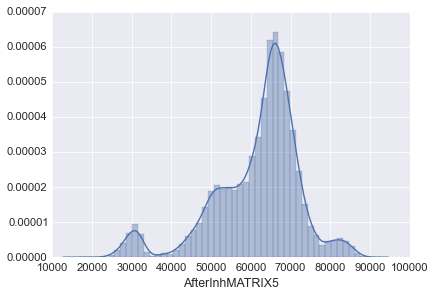

In [4]:
feature = "AfterInhMATRIX5"
sns.distplot(data_df.query("label == 1")[feature])

#### Extract the values of the KDE curve for fitting purposes

In [5]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pylab as plt

# Put the data you want to apply the KDE to into an array
data = data_df.query("label == 1")[feature].values[:, np.newaxis]
# Create a KDE object and then fit it to the data
kde = KernelDensity(kernel='gaussian', bandwidth=1400).fit(data)

#### Let's plot it to make sure it looks like what we've seen above

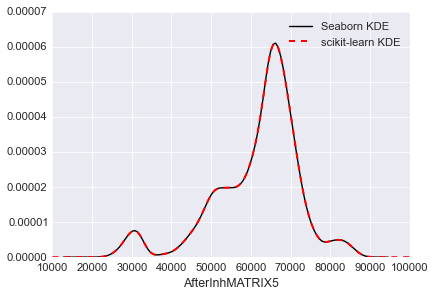

In [6]:
X_plot = np.linspace(10000, 100000, 1000)[:, np.newaxis]
# Get log density values for each point on the x-axis
log_dens = kde.score_samples(X_plot)
Y_plot = np.exp(log_dens)

# Plot the two against each other
sns.distplot(data_df.query("label == 1")[feature],
             hist=False, color='black',
             label='Seaborn KDE')
plt.plot(X_plot, Y_plot, '--', color='red', lw=2,
         label='scikit-learn KDE')
plt.legend(loc='best')

**Good!** It looks like it matches exactly.

### 3. Postulate a Fit Function
I'm guessing that this is four Gaussian functions added together.

* Define a Gaussian function
* Define our custom function made up of Gaussians
* Make a guess at our parameters
* Use scipy.optimize.curve_fit to optimize the parameters

$$ f_{G}(x) = a \cdot exp\left( -\frac{(x-\mu)^2}{2\sigma^2} \right) $$

In [7]:
def gauss_dist(xdata, amp, mean, stddev):
    return (amp * np.exp( np.divide(-1 * np.square(xdata-mean),
                                    (2 * stddev**2))))

In [8]:
# Take four amplitudes, means, and standard deviations
# Compute sum of four Gaussians
def my_fit(xdata,
           a1, a2, a3, a4,
           m1, m2, m3, m4,
           s1, s2, s3, s4):
    exp1 = gauss_dist(xdata, a1, m1, s1)
    exp2 = gauss_dist(xdata, a2, m2, s2)
    exp3 = gauss_dist(xdata, a3, m3, s3)
    exp4 = gauss_dist(xdata, a4, m4, s4)
    return exp1 + exp2 + exp3 + exp4

####Here I make my ballpark guesses for the amplitudes, means, and deviations

In [9]:
p0 = [0.00001, 0.00002, 0.000061, 0.000005,
      31000, 51000, 66000, 83000,
      1000, 1500, 2000, 3000]

#### Take a look at what that gives us

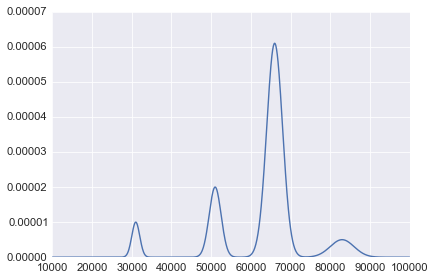

In [10]:
my_guess = my_fit(X_plot[:, 0], *p0)
plt.plot(X_plot, my_guess, '-')

... This looks not good, but it's a nice little nucleation point for an optimization routine.

## 4. Use scipy.stats to fit the function to the distribution

In [11]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(my_fit, X_plot[:, 0], Y_plot, p0)

#### Put in these optimized parameters and see what we get

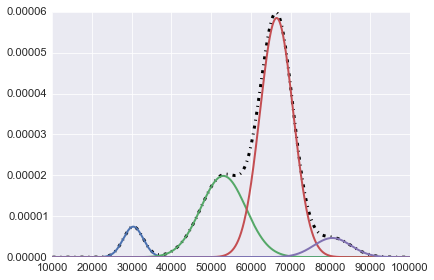

In [12]:
optim_fit = my_fit(X_plot[:, 0], *popt)
# Plot the whole fit
plt.plot(X_plot, optim_fit, '-.', lw=3, color='black')
# Along with the consituent gaussians
for i in range(0,4):
    plt.plot(X_plot,
             gauss_dist(X_plot[:, 0], popt[i], popt[i+4], popt[i+8]),
             '-', lw=2)

#### Compare to the actual KDE distribution

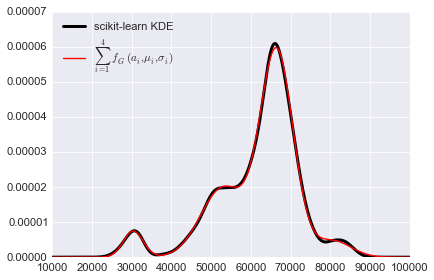

In [13]:
plt.plot(X_plot, Y_plot, '-', lw=3, color='black',
         label='scikit-learn KDE')
plt.plot(X_plot, optim_fit, '-', color='red',
         label=r'$\sum_{i=1}^4\ f_G(a_i, \mu_i, \sigma_i)$')
plt.legend(loc='best')

#### I'd say that's pretty good for a first go

# Calculate a $\chi^2$ value for this fit

With the hypothesis that these two distributions are the same, we calculate:
$$ \chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i} $$

In [14]:
def calc_chisq(obs, exp):
    chisq = 0.0
    for i in range(0,len(obs)):
        chisq += (obs[i] - exp[i])**2 / exp[i]
    return chisq

In [15]:
print calc_chisq(Y_plot, optim_fit)

0.0482006570666


For 12 degrees of freedom (12 fit parameters), we can look at a [$\chi^2$ table](http://sites.stat.psu.edu/~mga/401/tables/Chi-square-table.pdf) to find that we have a $p>0.995$ that this is a good fit to the distribution.

#### Or use scipy.stats to get the $\chi^2$ and p-value

In [16]:
from scipy.stats import chisquare
chisq, pvalue = chisquare(Y_plot, optim_fit, ddof=12)
print ("Chi-squared: %.02f\np-value: %.02f" % (chisq, pvalue))

Chi-squared: 0.05
p-value: 1.00


# Overlay onto original data

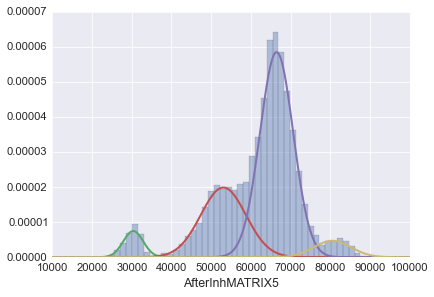

In [17]:
sns.distplot(data_df.query("label == 1")[feature],
             kde=False, hist=True, norm_hist=True)
for i in range(0,4):
    plt.plot(X_plot,
             gauss_dist(X_plot[:, 0], popt[i], popt[i+4], popt[i+8]),
             '-', lw=2)